# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


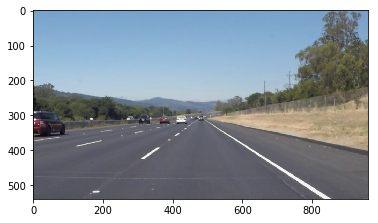

In [8]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image) # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

#### Some helper functions for various calculations that are necessary

In [2]:
import math

# constants
ROI_HOFFSET = 50  # pixels left and right of center, used to bound upper corners of roi
ROI_VOFFSET = 50  # pixels below center, used to bound upper corners of roi
INTERSECTION_OFFSET = 20  # pixels below intersection of two lanes, for roi adjustments
SLOPE_EPSILON = 0.12  # margin of error for bucketing slopes


def calc_roi_vertices(image_shape, h_offset=ROI_HOFFSET, v_offset=ROI_VOFFSET):
    """
    Returns four vertices (int_x, int_y) representing polygon as region of interest (roi).
    h_offset and v_offset can be adjusted to change the roi size.
    """
    left_bottom_x = 0
    right_bottom_x = image_shape[1]
    left_bottom_y = right_bottom_y = image_shape[0]
    
    left_top_x = int(image_shape[1] / 2) - h_offset
    right_top_x = int(image_shape[1] / 2) + h_offset
    left_top_y = right_top_y = int(image_shape[0] / 2) + v_offset

    return {'left_bottom': (left_bottom_x, left_bottom_y), 
            'right_bottom': (right_bottom_x, right_bottom_y),
            'right_top': (right_top_x, right_top_y),
            'left_top': (left_top_x, left_top_y)}


def adjust_roi_for_intersection(roi, intersection, offset=INTERSECTION_OFFSET):
    """
    We don't want our region of interest to include intersection of two lanes.
    This function can probably be improved, but for now it simply
    moves the upper boundary of the roi to be `offset` pixels below the intersection.
    
    Returns improved roi vertices.
    """
    x, y = intersection
    
    # only change roi if intersection is within image boundaries
    if y > 0:
        roi['right_top'] = (roi['right_top'][0], int(y) + offset)
        roi['left_top'] = (roi['left_top'][0], int(y) + offset) 
    return roi


def length(x1, y1, x2, y2):
    """Distance between two points (x1, y1) and (x2, y2)."""
    return math.hypot(x2 - x1, y2 - y1)


def slope(x1, y1, x2, y2):
    """Slope between two points (x1, y1) and (x2, y2)."""
    return (y2 - y1) / (x2 - x1)


def intersection(line1, line2):
    """
    Given parameters (m, b) of line1 and line2,
    returns (x, y) of their intersection.
    Returns Nones if parallel lines.
    """
    m1, b1 = line1
    m2, b2 = line2
    
    if m1 == m2:
        return None, None
    
    x = (b2 - b1) / (m1 - m2)
    y = m1 * x + b1    
    return x, y


def fit_average_line(points):
    """
    Given a list of points in form [(x1, y1, x2, y2), ...],
    returns the parameters for a line (m, b)
    that is the average representation of all the points.
    """
    ms = []
    bs = []
    for x1, y1, x2, y2 in points:
        m = slope(x1, y1, x2, y2)
        b = y1 - m * x1
        ms.append(m)
        bs.append(b)  
    return np.mean(ms), np.mean(bs)


def calc_points_in_roi(m, b, roi):
    """
    Given parameters for a line (m, b) and vertices for roi,
    returns x1, y1, x2, y2 for the section of line that passes through roi.
    Returns Nones if line does not pass through roi.
    """
    roi_max_y = roi['left_bottom'][1]
    roi_min_y = roi['left_top'][1]
    
    x1 = int((roi_min_y - b) / m)
    x2 = int((roi_max_y - b) / m)
    
    roi_min_x = roi['left_bottom'][0]
    roi_max_x = roi['right_bottom'][0]
    
    if x1 < roi_min_x or x1 > roi_max_x or x2 < roi_min_x or x2 > roi_max_x:
        return None, None, None, None  
    return x1, roi_min_y, x2, roi_max_y


def calc_length_in_roi(m, b, roi):
    """
    Given parameters for a line (m, b) and vertices for roi,
    returns the length of line that passes through roi.
    Returns 0 if line does not pass through roi.
    """
    x1, y1, x2, y2 = calc_points_in_roi(m, b, roi)
    return 0 if not x1 else length(x1, y1, x2, y2)


def average_past_n_frames(right_lane, left_lane, past_n_frames):
    """
    Returns the average right and left lanes, given a list of past_n lanes.
    """
    m_r_sum = m_l_sum = b_r_sum = b_l_sum = r_count = l_count = 0
    for past_right_lane, past_left_lane in past_n_frames:
        if past_right_lane:
            m_r_sum += past_right_lane[0]
            b_r_sum += past_right_lane[1]
            r_count += 1
        if past_left_lane:
            m_l_sum += past_left_lane[0]
            b_l_sum += past_left_lane[1]
            l_count += 1
    if right_lane:
        m_r_sum += right_lane[0]
        b_r_sum += right_lane[1]
        r_count += 1
    if left_lane:
        m_l_sum += left_lane[0]
        b_l_sum += left_lane[1]
        l_count += 1

    right_lane = (m_r_sum / r_count, b_r_sum / r_count) if r_count > 0 else None
    left_lane = (m_l_sum / l_count, b_l_sum / l_count) if l_count > 0 else None  
    return right_lane, left_lane

##### Below are the helper functions containing the separate steps of the pipeline:
1. **color_mask**: selecting for white and yellow 
2. **gaussian_blur**
3. **grayscale**
4. **canny**: edge detection
5. **region_of_interest**: masking image for roi polygon
6. **hough_lines**: line detection
7. **draw_lines**
8. **weighted_img**

In [3]:
def color_mask(img):
    """
    Returns image after the following transformations:
        - BGR -> HSV for better yellow color detection
        - BGR -> HSL for better white color detection
        - mask image to select for white and yellow colors (lanes)
    """
    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    lower_yellow = np.array([20,100,100])
    upper_yellow = np.array([40,255,255])
    yellow_mask = cv2.inRange(hsv_img, lower_yellow, upper_yellow)

    hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    lower_white = np.array([0,200,0])
    upper_white = np.array([255,255,255])
    white_mask = cv2.inRange(hls_img, lower_white, upper_white)

    white_yellow_mask = cv2.bitwise_or(white_mask, yellow_mask)
    return cv2.bitwise_and(img, img, mask=white_yellow_mask)


def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


def grayscale(img):
    """Applies the Grayscale transform"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)


def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    # defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    
    # needs to be in particular order
    vertices = [vertices['left_top'], vertices['right_top'],
                vertices['right_bottom'], vertices['left_bottom']]
    # filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, np.array([vertices]), ignore_mask_color)
    
    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform. 
    Returns lines calculates by HoughLinesP.
    """
    return cv2.HoughLinesP(img, rho, theta, threshold, np.array([]),
                           minLineLength=min_line_len, maxLineGap=max_line_gap)


def draw_lines(img, lines, color=[255, 0, 0], thickness=10, past_n_frames=None):
    """
    This function does the following:
    1) separates lines by slope
    2) for each bucket, finds average (m, b) for fitted line
    3) finds the longest right and left lanes
    4) (optional) averages (m, b) with past_n_frames
    5) finds the intersection and adjust roi
    6) draws left and right lanes, if they exist
    7) returns left and right lanes
    """
    buckets = {}
    
    # separate lines into buckets by slope
    for line in lines:
        for x1, y1, x2, y2 in line:
            s = slope(x1, y1, x2, y2)
            found_bucket = False
            for b in buckets:
                if abs(s - b) <= SLOPE_EPSILON:
                    buckets[b].append((x1, y1, x2, y2))
                    found_bucket = True
                    
            if not found_bucket:
                buckets[s] = [(x1, y1, x2, y2)]
    
    # fit an average line for each bucket
    lines_n_slope = []
    lines_p_slope = []
    for b in buckets:
        m, b = fit_average_line(buckets[b])
        # ignore results with 0 slope
        if m == 0:
            continue
        
        if m > 0:
            lines_p_slope.append((m, b))
        else:
            lines_n_slope.append((m, b))
    
    # sort by length of lines in roi
    # pick the longest neg sloping line as right lane and pos sloping line as left lane
    roi = calc_roi_vertices(img.shape)
    for lines in [lines_p_slope, lines_n_slope]:
        if len(lines) > 1:
            lines.sort(key=lambda x: calc_length_in_roi(x[0], x[1], roi), reverse=True)
    right_lane = lines_n_slope[0] if len(lines_n_slope) > 0 else None
    left_lane = lines_p_slope[0] if len(lines_p_slope) > 0 else None
    
    # save values to return
    curr_right_lane = right_lane
    curr_left_lane = left_lane
    
    # if previous frames given, recalculate lane lines by taking average
    if past_n_frames:
        right_lane, left_lane = average_past_n_frames(right_lane, left_lane, past_n_frames)
    
    # find intersection and adjust roi to exclude it
    if right_lane and left_lane:
        x, y = intersection(right_lane, left_lane)
        if x and y:
            roi = adjust_roi_for_intersection(roi, (x, y))
    
    # draw lanes, if they exist
    if right_lane:
        x1, y1, x2, y2 = calc_points_in_roi(right_lane[0], right_lane[1], roi)
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    if left_lane:
        x1, y1, x2, y2 = calc_points_in_roi(left_lane[0], left_lane[1], roi)
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)

    return curr_right_lane, curr_left_lane    


def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [5]:
import os
TEST_IMAGES_DIR = 'test_images/'
TEST_IMAGES_OUTPUT_DIR = 'test_images_output/'
print(os.listdir(TEST_IMAGES_DIR))

['solidWhiteCurve.jpg', 'solidWhiteRight.jpg', 'solidYellowCurve.jpg', 'solidYellowCurve2.jpg', 'solidYellowLeft.jpg', 'whiteCarLaneSwitch.jpg']


## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [4]:
class LaneFinderPipeline(object):
    # tuned parameters for pipeline
    GAUSSIAN_KERNEL_SIZE = 3

    CANNY_LOW_THRESHOLD = 100
    CANNY_HIGH_THRESHOLD = 200
    
    RHO = 1
    THETA = np.pi/180
    THRESHOLD = 25
    MIN_LINE_LEN = 5
    MAX_LINE_GAP = 20

    def __init__(self, n_frames=None):
        self.n_frames = n_frames
        self.past_n_frames = []
    
    def process_image(self, image):
        masked_img = color_mask(image)
        grayed_img = grayscale(masked_img)    
        blurred_img = gaussian_blur(grayed_img, LaneFinderPipeline.GAUSSIAN_KERNEL_SIZE)
        canny_img = canny(blurred_img, 
                          LaneFinderPipeline.CANNY_LOW_THRESHOLD, 
                          LaneFinderPipeline.CANNY_HIGH_THRESHOLD)
        roi_img = region_of_interest(canny_img, calc_roi_vertices(image.shape))
        lines = hough_lines(
            roi_img, 
            LaneFinderPipeline.RHO, 
            LaneFinderPipeline.THETA, 
            LaneFinderPipeline.THRESHOLD, 
            LaneFinderPipeline.MIN_LINE_LEN, 
            LaneFinderPipeline.MAX_LINE_GAP)
        # initiate line_img
        line_img = np.zeros((roi_img.shape[0], roi_img.shape[1], 3), dtype=np.uint8)
        right_lane, left_lane = draw_lines(line_img, lines, past_n_frames=self.past_n_frames)

        if self.n_frames:
            if len(self.past_n_frames) >= self.n_frames:
                self.past_n_frames = self.past_n_frames[1: self.n_frames]
            self.past_n_frames.append([right_lane, left_lane])

        return weighted_img(line_img, image)

In [6]:
def process_images(images, save_img_path=None):
    for img in images:
        input_path = os.path.join(TEST_IMAGES_DIR, img)
        # read and process image
        pipeline = LaneFinderPipeline()
        processed_img = pipeline.process_image(mpimg.imread(input_path))
        # show processed image
        plt.figure()
        plt.imshow(processed_img)
        # save processed image
        if save_img_path:
            plt.imsave(save_img_path, processed_img)

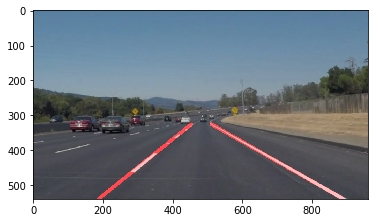

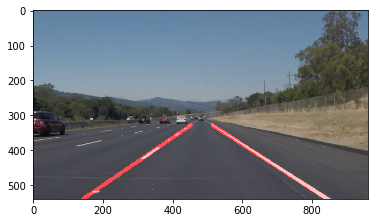

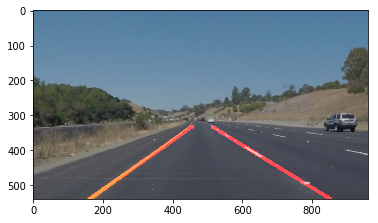

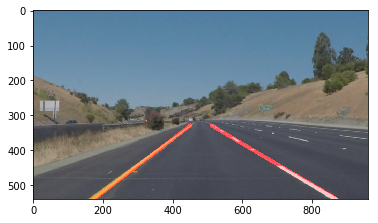

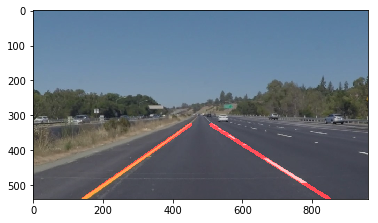

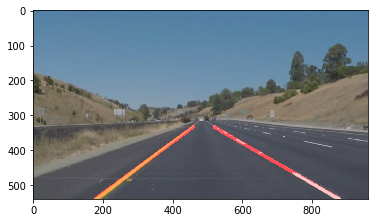

In [10]:
process_images(os.listdir(TEST_IMAGES_DIR))

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

N_FRAMES = 10  # number of past image frames to apply averaging, smoothens video

In [12]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
pipeline = LaneFinderPipeline(n_frames=N_FRAMES)
white_clip = clip1.fl_image(pipeline.process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:04<00:00, 53.83it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 5.22 s, sys: 1.26 s, total: 6.48 s
Wall time: 4.54 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [14]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
pipeline = LaneFinderPipeline(n_frames=N_FRAMES)
yellow_clip = clip2.fl_image(pipeline.process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:12<00:00, 56.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 16.4 s, sys: 4.58 s, total: 21 s
Wall time: 12.7 s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [16]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
pipeline = LaneFinderPipeline(n_frames=N_FRAMES)
challenge_clip = clip3.fl_image(pipeline.process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:08<00:00, 30.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 10.3 s, sys: 2.59 s, total: 12.9 s
Wall time: 9.1 s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))